### Author - Vikram Patil

##### Environment: Python 3.6.1 and Jupyter notebook

# Table of contents
#### 1.1 [Importing libraries](#library)
#### 1.2. [Load and process the data](#loadnprocess)      
* ####     1.2.1 [Load data](#load)
* ####     1.2.2 [Process data](#process)


#### 1.3. [Exploratory data analysis & Cleaning](#eda)
* ####      1.3.1 [Checking nulls](#null)
* ####      1.3.2 [Checklist name - replacing all duplicates names with original](#checknameduplicates)
* ####      1.3.3 [Checklist name - removing names with more than 100characters](#checkname100)
* ####      1.3.4 [removing names which has blank values; example '..'](#checknameblank)

#### 1.4. [Creating checklist template corpus for recommendation](#corpus)
* ####      1.4.1 [Combine header_label,header_type,item_lable and item_type columns](#combine)
* ####      1.4.2 [Clean the text](#cleantext)
* ####      1.4.3 [Feature creation using TF-IDF approach](#feature)
* ####      1.4.4 [Using cosine_similarity, predicting recommendation of check-list names per industry](#cosine)

#### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### [Question 2) - Suggestion on potential checklist items for a checklist name](#q2)

* ####      2.1 [Identify clusters](#2.1)
* ####      2.2 [Pre-process item-label column](#2.2)
* ####      2.3 [TF_IDF is applied and K-means clsutering technique is used to cluster the data](#2.3)
* ####      2.4 [Prediction on test data](#2.4)


#### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### [Q3 - To find the potential risks between the checklist items](#q3)
* ####      3.1 [Column Item-label is selected and Text processing is applied, item-label is further cleaned](#3.1)
* ####      3.2 [TF-IDF is applied to generate the Bigram - features](#3.2)
* ####      3.3 [Correlation matrix is calculated for each bigram](#3.3)
* ####      3.4 [Sample output](#3.4)

#### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 1.1 Importing libraries <a name="library"></a>

In [2]:
import json
import pandas as pd
from pandas.io.json import json_normalize
import warnings
from functools import reduce
import numpy as np
import nltk
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

pd.options.display.max_rows=100

C:\Users\vikra\AppData\Roaming\Python\Python36\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


## 1.2  Load and process data<a name="loadnprocess"></a>

### 1.2.1 Load the data<a name="load"></a>

In [3]:
json_file_path="sample_pl_data.json"


with open(json_file_path, 'r') as file:
     contents = json.loads(file.read())

### 1.2.2 Process the data<a name="process"></a>

In [4]:
#--------------------------
# Parsing JSON data
#--------------------------

def find_info(data,temp_type):
    """ 
    This function parses the json and finds the required data such as metadata, metrics, item and header
    
    input = json data and required template_type (metadata, metrics, item and header)
    output = respective template_type dataframe
    """
    
    if temp_type =="metadata":
        test = pd.io.json.json_normalize(data, record_path=[['template_data','metadata']],\
                                  meta=['template_id','name',['template_data','metadata']],\
                                 errors='ignore')
        test = test.join(json_normalize(test["template_data.metadata"].tolist()).add_prefix("metadata.")).\
        drop(["template_data.metadata"], axis=1)
        test = test[['template_id','name','metadata.industry','metadata.subindustry','metadata.name']]
        
        
    if temp_type=="metrics":
        test = pd.io.json.json_normalize(data, record_path=[['template_data','metrics']],\
                              meta=['template_id','name',['template_data','metrics']],\
                             errors='ignore')
        test = test.join(json_normalize(test["template_data.metrics"].tolist()).add_prefix("metrics."))\
                .drop(["template_data.metrics","metrics.duration_count","metrics.est_duration",\
                     "metrics.date_last_used","metrics.avg_duration"], axis=1)
        test.drop([0], axis = 1,inplace=True) 
        
    
    if temp_type=="item":
        test = pd.io.json.json_normalize(data, record_path=[['items']],\
                          meta=['template_id','name'],\
                         errors='ignore')
        test = test[['template_id','name','item_id','parent_id','type','label']]
        test.rename(columns={'type':'item_type','label':'item_label','parent_id':'item_parent_id'},inplace=True)
        
        
    if temp_type=="header":
        test = pd.io.json.json_normalize(data, record_path=[['header']],\
                          meta=['template_id','name'],\
                         errors='ignore')
        test = test[['template_id','name','item_id','parent_id','type','label']]
        test.rename(columns={'type':'header_type','label':'header_label','parent_id':'header_parent_id',\
                            'item_id':'header_id'},inplace=True)
        
    return test

In [5]:
metric_df = find_info(contents,"metrics")
metadata_df = find_info(contents,"metadata")
item_df = find_info(contents,"item")
header_df = find_info(contents,"header")

#### Four dataframe are merged to form final dataframe

In [6]:
def merge_df(df1,df2,df3,df4):
    merge_df=df1.merge(df2.drop_duplicates(),on=['template_id','name'],how="left")
    merge_df=merge_df.merge(df3.drop_duplicates(),on=['template_id','name'],how="left")
    merge_df=merge_df.merge(df4.drop_duplicates(),on=['template_id','name'],how="left")
    merge_df.reset_index(inplace=True,drop=True)
    return merge_df

In [7]:
# merging all four dataframes
dff = merge_df(item_df,metadata_df,header_df,metric_df)
dff.shape

(118801, 15)

In [8]:
# printing sample output
dff.head()

,template_id,name,item_id,item_parent_id,item_type,item_label,metadata.industry,metadata.subindustry,metadata.name,header_id,header_parent_id,header_type,header_label,metrics.use_count,metrics.rating
0,template_65db0caaac874d08ae7e7d15d05b5c7c,All items - duplicate,95594086-34f0-4680-b43b-78fa330c70a0,None,section,Audit,-2,-2,All items - duplicate,6f6f5e7f-9787-4a06-a4bc-7baf1c5f23b3,None,section,Title Page,12,-1
1,template_65db0caaac874d08ae7e7d15d05b5c7c,All items - duplicate,95594086-34f0-4680-b43b-78fa330c70a0,None,section,Audit,-2,-2,All items - duplicate,f3245d46-ea77-11e1-aff1-0800200c9a66,6f6f5e7f-9787-4a06-a4bc-7baf1c5f23b3,textsingle,Document No.,12,-1
2,template_65db0caaac874d08ae7e7d15d05b5c7c,All items - duplicate,95594086-34f0-4680-b43b-78fa330c70a0,None,section,Audit,-2,-2,All items - duplicate,f3245d40-ea77-11e1-aff1-0800200c9a66,6f6f5e7f-9787-4a06-a4bc-7baf1c5f23b3,textsingle,Audit Title,12,-1
3,template_65db0caaac874d08ae7e7d15d05b5c7c,All items - duplicate,95594086-34f0-4680-b43b-78fa330c70a0,None,section,Audit,-2,-2,All items - duplicate,f3245d41-ea77-11e1-aff1-0800200c9a66,6f6f5e7f-9787-4a06-a4bc-7baf1c5f23b3,textsingle,Client / Site,12,-1
4,template_65db0caaac874d08ae7e7d15d05b5c7c,All items - duplicate,95594086-34f0-4680-b43b-78fa330c70a0,None,section,Audit,-2,-2,All items - duplicate,f3245d42-ea77-11e1-aff1-0800200c9a66,6f6f5e7f-9787-4a06-a4bc-7baf1c5f23b3,datetime,Conducted on,12,-1


In [9]:
df=dff.copy()  # saving a copy of final dataframe

#### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


## 1.3 Exploratory Data analysis & Cleaning<a name="eda"></a>


In [10]:
df.dtypes

template_id             object
name                    object
item_id                 object
item_parent_id          object
item_type               object
item_label              object
metadata.industry        int64
metadata.subindustry     int64
metadata.name           object
header_id               object
header_parent_id        object
header_type             object
header_label            object
metrics.use_count        int64
metrics.rating           int64
dtype: object

### 1.3.1 Checking for any nulls present<a name="null"></a>

In [11]:
df.isnull().sum()

template_id                0
name                      56
item_id                    0
item_parent_id          2599
item_type                  0
item_label              7690
metadata.industry          0
metadata.subindustry       0
metadata.name              0
header_id                  0
header_parent_id        6326
header_type                0
header_label            1135
metrics.use_count          0
metrics.rating             0
dtype: int64

#### removing any blank spaces and removing all nulls present

In [12]:
df= df.replace(r'^\s*$', np.nan, regex=True) # replace blank spaces with null values
df = df.dropna(how='any',axis=0) # dropping all nulls in data

In [13]:
df.isnull().sum()

template_id             0
name                    0
item_id                 0
item_parent_id          0
item_type               0
item_label              0
metadata.industry       0
metadata.subindustry    0
metadata.name           0
header_id               0
header_parent_id        0
header_type             0
header_label            0
metrics.use_count       0
metrics.rating          0
dtype: int64

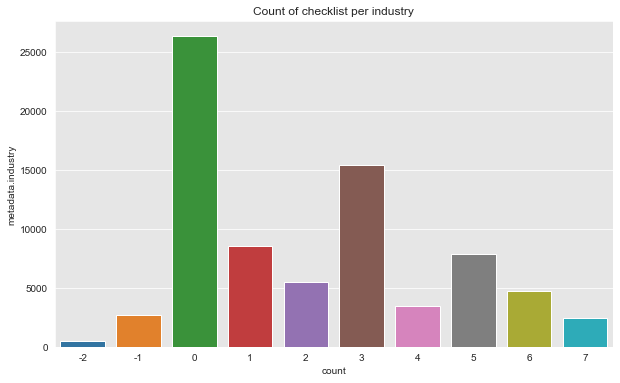

In [14]:
#Visualization of data set
a = df['metadata.industry'].value_counts()
a = pd.DataFrame(a)
a['count'] = a.index
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(y='metadata.industry', x='count', data=a).set_title('Count of checklist per industry')
plt.show()

#### From above, we can observe that industry 0 has the most numebr of checklist template in the data

### 1.3.2 Checklist name - replacing all duplicates names with original<a name="checknameduplicates"></a>

In [15]:
dff[dff['name'].str.contains("duplicate")==True]['name'].unique().tolist()


['All items - duplicate',
 'Restest - duplicate',
 'asdasdsa - duplicate - duplicate - duplicate',
 'asdasdsa - duplicate - duplicate',
 'asdasdsa - duplicate - duplicate - duplicate - duplicate',
 'Example of complex template - 2 should be converted - duplicate',
 'All possible field that should be converted - duplicate',
 'UseIt to Start the day - duplicate',
 'All items template 123 - duplicate']

##### From above, we can confirm that the checkist names have duplicate names and this can be treated by removing the duplicate keyword

In [16]:
# Removing Duplicate keyword
df.name = df.name.replace({"All items - duplicate": "All items template 123",\
                          "All items template 123 - duplicate":"All items template 123",\
                          'Restest - duplicate':'Restest',\
                          'asdasdsa - duplicate - duplicate - duplicate':'asdasdsa',\
                          'asdasdsa - duplicate - duplicate':'asdasdsa',\
                          'asdasdsa - duplicate - duplicate - duplicate - duplicate':'asdasdsa',\
'Example of complex template - 2 should be converted - duplicate':'Example of complex template - 2 should be converted',\
                'All possible field that should be converted - duplicate':'All possible field that should be converted',\
                          'UseIt to Start the day - duplicate':'UseIt to Start the day'})


### 1.3.3 Checklist name - removing names with more than 100characters<a name="checkname100"></a>

In [17]:
df = df[df['name'].str.len() < 100]


### 1.3.4 Checklist name - removing names which has blank values; example '..'<a name="checknameblank"></a>

In [18]:
df = df[df['name'].str.contains('[A-Za-z]')]

In [19]:
df['name'] = df['name'].map(lambda x: x.strip())

#### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


### Selecting only required columns and taking random data of rows 2000

In [20]:
df_cluster = df[['name','item_type','item_label','header_type','header_label','metadata.industry']]
df_cluster.shape

(77390, 6)

In [21]:
df_sample = df_cluster.sample(20000)
df_sample.reset_index(drop=True,inplace=True)
df_sample.shape

(20000, 6)

## 1.4. Creating checklist template corpus for recommendation <a name="corpus"></a>

### Approach
* #### Combine header_label,header_type,item_lable and item_type columns
* #### Clean the text
* #### Feature creation using TF-IDF approach
* #### Using cosine_similarity, predicting recommendation of check-list names per industry

### 1.4.1 Combine header_label,header_type,item_lable and item_type columns<a name="combine"></a>

In [22]:
df_sample['it_il_ht_hl'] = df_sample['header_type']+" "+df_sample['header_label'] +" "+\
df_sample['item_type']+" "+df_sample['item_label']

df_sample = df_sample[['metadata.industry','name','it_il_ht_hl']]

### 1.4.2 Clean the text<a name="cleantext"></a>

In [23]:
stopwords = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()

#-------------------------------------------
# Data cleaning into required format for NLP
#------------------------------------------

def clean_text(text):
    """
    Input is a string of text, then performs the following:
        1. converts to lower and removes puncutations
        2. Splits the sentence into tokens
        3. Removes any digits present
        4. Lemmatization, reduces words to their base wordcand removes stop words
        5. Removes tokens if its length is 2 chracters or less
        6. Returns the sentence of the cleaned text
    """
    text = "".join([word.lower() for word in text if word not in string.punctuation])#[1]
    tokens = re.split('\W+', text)#[2]
    tokens=[word for word in tokens if word.isalpha()] #[3]
    tokens = [wn.lemmatize(word) for word in tokens if word not in stopwords]#[4]
    text = " ".join([word for word in tokens if len(word)>3])#[5]
    return text

In [24]:
df_sample['clean'] =df_sample.apply(lambda x :clean_text(x['it_il_ht_hl']),axis=1)
# new column clean contains the new version of data for next stages

In [25]:
df_sample.head()

,metadata.industry,name,it_il_ht_hl,clean
0,0,Example of complex template - order page,text Prepared by information is one of Safe NA,text prepared information safe
1,6,Vehicle Inventory 115A,address Station/Location question Keys,address stationlocation question
2,0,Example of complex template - 2 should be conv...,"information response if one of 1,3 list 1 2 3 ...",information response list question multiple ch...
3,1,Cleaning - Weekly Site Inspection V1.9,text Prepared by category Food courts,text prepared category food court
4,6,iOS Templar’s complex,datetime Conducted on information Info text,datetime conducted information info text


### 1.4.3 Feature creation using TF-IDF approach<a name="feature"></a>

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define vectorizer parameters
    # Selecting unigram,bigram and trigrams
    # ignore terms that appear in less than 1% of the documents
    # ignore terms that appear in more than 95% of the documents

tfidf_vectorizer = TfidfVectorizer(max_df=0.95,min_df=0.01,
                                 use_idf=True, ngram_range=(1,3))

In [27]:
# Passing the cleaned data to TF-IDF vectoriser

tfidf_clean = tfidf_vectorizer.fit_transform(df_sample['clean'])
X_features=pd.DataFrame(tfidf_clean.toarray(),columns=tfidf_vectorizer.get_feature_names())
X_features.shape

(20000, 173)

### 1.4.4 Using cosine_similarity, predicting recommendation of check-list names per industry<a name="cosine"></a>

In [28]:
# selecting a test - industry and check-list name for prediction

industry =7
checklist_name = "ATM Installation Snagging Report"

test_df = df_cluster[(df_cluster['metadata.industry']==industry) & (df_cluster['name']==checklist_name)].iloc[[0]]
test_df

,name,item_type,item_label,header_type,header_label,metadata.industry
116882,ATM Installation Snagging Report,category,ATM Details,text,Site Number:,7


In [29]:
from sklearn.metrics.pairwise import cosine_similarity
indus_tfidf = tfidf_vectorizer.transform(test_df['name'])
cos_similarity_tfidf = map(lambda x: cosine_similarity(indus_tfidf, x),tfidf_clean)

In [30]:
def get_recommendation(top, df_all):
    """
    Provides recommendation
      input = top; which contains the sorted list of cosine similarity factor. And datframe
      output= recommendation dataframe which contains the checklist template names
    """
    
    recommendation = pd.DataFrame(columns = ['name'])
    count = 0
    for i in top:
        recommendation.at[count, 'name'] = df_all['name'][i]
        count += 1
    return recommendation

output= list(cos_similarity_tfidf)
top = sorted(range(len(output)), key=lambda i: output[i], reverse=True)[:10]

#### below is the sample output

In [31]:
print("Top 10 checklist items recommendation for customer/industry= {} and checklist title= {}".\
      format(industry,checklist_name))
get_recommendation(top,df_sample)

Top 10 checklist items recommendation for customer/industry= 7 and checklist title= ATM Installation Snagging Report


,name
0,Example of complex template - order page
1,Vehicle Inventory 115A
2,Example of complex template - 2 should be conv...
3,Cleaning - Weekly Site Inspection V1.9
4,iOS Templar’s complex
5,Example of complex template - order page
6,Example of complex template - 2 should be conv...
7,All possible field that should be converted
8,Centre Excellence Review
9,Civil Project OHS Audit


#### Q-1) Conclusion - Based on the findings of above, we can recommend all required checklist templates  based on customer(industry) and different checklist titles.

#### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Question 2) - Suggestion on potential checklist items for a checklist name<a name="q2"></a>


#### Approach: Using K-means clustering 

* ####  2.1) Identify clusters
* ####  2.2) Pre-process item-label column
* ####  2.3) TF_IDF is applied and K-means clsutering technique is used to cluster the data
* ####  2.4) Prediction on test data

#### 2.1 Identify Clusters<a name="2.1"></a>

In [353]:
# Sample data is taken

dfq2 = df_cluster.sample(20000)
dfq2.reset_index(drop=True,inplace=True)
dfq2.shape

(20000, 6)

In [354]:
dfq2.head()

,name,item_type,item_label,header_type,header_label,metadata.industry
0,UseIt to Start the day,checkbox,Include a spoon if required.,address,Location,2
1,Hatching Operation Audit,question,The bibliography is sleazy and unmatched?,textsingle,Audit Title,-1
2,Construction Site HSE Audit UK,question,Be checked and replenished on a regular basis.,datetime,Conducted on,3
3,Example of complex template - 2 should be conv...,information,If >= 14,address,Location,0
4,CHURCH SAFETY SELF-INSPECTION FORM,category,CHECKLIST,datetime,Conducted on,-1


#### Total unique text present in "name" column gives us an idea how to determine total clusters

In [400]:
unique_name_df = pd.DataFrame(dfq2['name'].unique(),columns=["unique_names"])
clusters = len(dfq2['name'].unique())

print("Number of clusters is same as total number of unique checklist items present={}".format(clusters))


Number of clusters is same as total number of unique checklist items present=76


#### 2.2 Pre-process item-label column<a name="2.2"></a>

In [356]:
dfq2['clean_item_label'] =dfq2.apply(lambda x :clean_text(x['item_label']),axis=1)
dfq2= dfq2.replace(r'^\s*$', np.nan, regex=True) # replace blank spaces with null values
dfq2 = dfq2.dropna(how='any',axis=0) # dropping all nulls in data
dfq2.reset_index(drop=True,inplace=True)


In [357]:
dfq2.head()

,name,item_type,item_label,header_type,header_label,metadata.industry,clean_item_label
0,UseIt to Start the day,checkbox,Include a spoon if required.,address,Location,2,include spoon required
1,Hatching Operation Audit,question,The bibliography is sleazy and unmatched?,textsingle,Audit Title,-1,bibliography sleazy unmatched
2,Construction Site HSE Audit UK,question,Be checked and replenished on a regular basis.,datetime,Conducted on,3,checked replenished regular basis
3,CHURCH SAFETY SELF-INSPECTION FORM,category,CHECKLIST,datetime,Conducted on,-1,checklist
4,Hatching Operation Audit,category,Frowns,textsingle,Client / Site,-1,frown


#### 2.3 TF_IDF is applied and K-means clsutering technique is used to cluster the data<a name="2.3"></a>


In [340]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer2 = TfidfVectorizer(max_df=0.95,min_df=0.01,
                                 use_idf=True, ngram_range=(1,3))

In [358]:
tfidf_itemlabel = tfidf_vectorizer2.fit_transform(dfq2['clean_item_label'])
X_il_features2=pd.DataFrame(tfidf_itemlabel.toarray(),columns=tfidf_vectorizer2.get_feature_names())
X_il_features2.shape

(18225, 98)

In [359]:
from sklearn.cluster import KMeans
import collections

km_model = KMeans(n_clusters=clusters)

km_model.fit(X_il_features2)
clustering = collections.defaultdict(list)

In [360]:
for idx, label in enumerate(km_model.labels_):
        clustering[label].append(idx)

#### 2.4 Prediction on test data<a name="2.4"></a>

In [450]:
# Taking a sample check list name, identifying its index location

checklist_name="General Site Safety Audit"

checklist_name_index = unique_name_df[unique_name_df['unique_names']==checklist_name].index[0]
unique_name_df[unique_name_df['unique_names']==checklist_name]

,unique_names
28,General Site Safety Audit



-----
#### Predicting all "item labels" for the checklist name = "General Site Safety Audit", index location=28

#### Below loop displays all the index location of "item labels" for the checklist name = "General Site Safety Audit", index location=28

In [451]:
for (k,v) in clustering.items():
    if k==checklist_name_index:
        print(k)
        print(v)

28
[433, 547, 567, 613, 677, 902, 1061, 1170, 1452, 1494, 2010, 2086, 2097, 2100, 2173, 2351, 2391, 2796, 2817, 2912, 3156, 3321, 3428, 3520, 3978, 4049, 4624, 4717, 4822, 4905, 5146, 5210, 5273, 5304, 5688, 5834, 5895, 6153, 6190, 6552, 6609, 6675, 7053, 7459, 7505, 7544, 7607, 7860, 7864, 7879, 8017, 8402, 8438, 8579, 9018, 9159, 9164, 9321, 9464, 9517, 9586, 9732, 9932, 9993, 10042, 10073, 10156, 10233, 10390, 10586, 10734, 10760, 10975, 10977, 11067, 11079, 11100, 11150, 11587, 11624, 11688, 11772, 11937, 12136, 12144, 12317, 12432, 12460, 12557, 12670, 13026, 13123, 13321, 13343, 13428, 13579, 13938, 14296, 14352, 14365, 14521, 14590, 14635, 14832, 14911, 15207, 15612, 15630, 15845, 15877, 16139, 16240, 16338, 16415, 16546, 16595, 16653, 16744, 16759, 17015, 17021, 17201, 17257, 17557, 17872, 17881]


#### Additional confirmation by checking the index location of "item labels" for the checklist name = "General Site Safety Audit"

In [440]:
dfq2.iloc[433]['item_label']

'Toilet requisite supply level'

In [442]:
dfq2.iloc[567]['item_label']

'Is there a system in place to test for drug and alcohol levels of workers?'

#### Conclusion: Using K-means clustering, for a particular checklist name, respective item labels are identified.

#### Thus, this technique can be used to improve customer experience

#### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Question#3 - To find the potential risks between the checklist items <a name="q3"></a>

### Approach

* #### 3-1) Column Item-label is selected and Text processing is applied, item-label is further cleaned
* #### 3-2) TF-IDF is applied to generate the Bigram - features
* #### 3-3) Correlation matrix is calculated for each bigram
* #### 3-4) Sample output

#### 3-1) Column Item-label is selected and Text processing is applied, item-label is further cleaned<a name="3.1"></a>

In [262]:
dfq3 = df_cluster.sample(1000) # taking sample of 1000
dfq3.reset_index(inplace=True, drop=True)


In [263]:
# based on function in 4.2, column item-label is processed
dfq3['item_label'] =dfq3.apply(lambda x :clean_text(x['item_label']),axis=1) 

dfq3= dfq3.replace(r'^\s*$', np.nan, regex=True) # replace blank spaces with null values
dfq3 = dfq3.dropna(how='any',axis=0) # dropping all nulls in data
dfq3.reset_index(drop=True,inplace=True)

dfq3 = dfq3[['name','item_label']]

In [279]:
dfq3.head()

,name,item_label
0,Example of complex template - 2 should be conv...,categ brocken
1,Vetting Inspection Report FL (form 1200),vessel provided adequate operator instruction ...
2,Civil Project OHS Audit,düşme durdurma önlemleri fall arrest measure
3,FS Compliance Assessment - latest,mystery shop attempted
4,Example of complex template - 2 should be conv...,pass


#### 3-2) TF-IDF is applied to generate the Bigram - features<a name="3.2"></a>

In [266]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(ngram_range=[2,2])

tfidf_matrix = tfidf_vectorizer.fit_transform(dfq3['item_label'])

In [267]:
X_features3=pd.DataFrame(tfidf_matrix.toarray(),columns=tfidf_vectorizer.get_feature_names())
X_features3.shape

(920, 2336)

#### 3-3) Correlation matrix is calculated for each bigram<a name="3.3"></a>

In [268]:
def find_corr_features(features):
    """
    This function generates correlated features and correlation matrix
    
    Input features generated in step 3-2
    Output contains highly correlated features and its matrix  
    """
    correlated_features = set()  
    correlation_matrix=features.corr()

    for i in range(len(correlation_matrix .columns)):  
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > 0.95:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
                
    return list(correlated_features),correlation_matrix

In [269]:
correlated_features,correlation_matrix = find_corr_features(X_features3)

#### Below is the sample of highly correlated features 


In [271]:

correlated_features

['match plan',
 'free rubbish',
 'time inspection',
 'least properly',
 'approved maintained',
 'record date',
 'working hour',
 'test tube',
 'handling application',
 'carriage grain',
 'test initial',
 'lead placed',
 'wastage corrosion',
 'plantequipment including',
 'paying particular',
 'type cargo',
 'garden mulched',
 'assign racs',
 'lokal kontrolü',
 'operator defined',
 'minimize vehicle',
 'response plan',
 'sivri nesneler',
 'information displayed',
 'swept cleaned',
 'code code',
 'embedded centre',
 'site securely',
 'includes testing',
 'inadequate amenity',
 'güvenliği ekipmanı',
 'implementation learning',
 'site adjacent',
 'regular inspection',
 'handling issue',
 'tank board',
 'person ensure',
 'inadequate communication',
 'lunch room',
 'changing child',
 'inch clearance',
 'child adjustment',
 'operating public',
 'traffic front',
 'practice qualified',
 'educator encourage',
 'breaking strength',
 'product safety',
 'afman paragraph',
 'düşme durdurma',
 'anyone

#### 3-4) Sample output<a name="3.4"></a>

##### From the above, if we select any one feature of interest for example = "inspection cargo" 
##### and below step presents how "inspection cargo" is impacted with other features which tells us to caution customer 

In [452]:
sample_feature='inspection cargo'


corr_df= abs(correlation_matrix)
corr_df = corr_df[corr_df[sample_feature] > 0.95][[sample_feature]]

print("--- Potential risks related to sample_feature='{}' are below --- \n\n {}".format(sample_feature,corr_df.index.tolist()))

--- Potential risks related to sample_feature='inspection cargo' are below --- 

 ['carry regular', 'cofferdam vessel', 'inspection cargo', 'personnel record', 'place carry', 'procedure place', 'record maintained', 'regular inspection', 'space trunk', 'tank void', 'trunk cofferdam', 'vessel personnel', 'void space']


#### Q3- conclusion: Above steps helps us to identify potential risks involved for individual inspection item